In [ ]:
#for SNAPS: 1,3,4,5,8,9,10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from GridDales import GridDales
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import Polygon

# Define transformation class
class Transform:
    def __init__(self, parameters):
        self.parameters = parameters
        self.crs_latlon = 'epsg:4326'
        self.crs_rd = 'epsg:28992'
        # Construct transformation objects
        self.latlon_to_xy_transform = Transformer.from_crs(self.crs_latlon, self.parameters['proj4'])
        self.xy_to_latlon_transform = Transformer.from_crs(self.parameters['proj4'], self.crs_latlon)
        self.rd_to_latlon_transform = Transformer.from_crs(self.crs_rd, self.crs_latlon)
        self.latlon_to_rd_transform = Transformer.from_crs(self.crs_latlon, self.crs_rd)
        self.rd_to_lcc_transform = Transformer.from_crs(self.crs_rd, self.parameters['proj4'])

    def latlon_to_xy(self, lat, lon):
        return self.latlon_to_xy_transform.transform(lat, lon)

    def xy_to_latlon(self, x, y):
        return self.xy_to_latlon_transform.transform(x, y)
    
    def rd_to_latlon(self, x, y):
        return self.rd_to_latlon_transform.transform(x, y)
    
    def latlon_to_rd(self, lat, lon):
        return self.latlon_to_rd_transform.transform(lat, lon)

    def rd_to_lcc(self, x, y):
        return self.rd_to_lcc_transform.transform(x, y)


# Load CSV containing the CO2 data
data_path = "co2_2018_SNAP_10_residual.csv"  #_refined_100m
df = pd.read_csv(data_path)

# Define projection parameters
proj_params = {
    'proj4': "+proj=lcc +lat_1=52.500000 +lat_2=52.500000 +lat_0=52.500000 +lon_0=0.000000 "
              "+k_0=1.0 +x_0=649536.512574 +y_0=1032883.739533 +a=6371229.0 +b=6371229.0"
}


transformer = Transform(proj_params)



# Define LES grid (target grid with 100x100m resolution)
grid_params = {
    'xsize': 172800,
    'ysize': 115200,
    'itot': 1728,
    'jtot': 1152,
    'kmax': 128,
    'dz0': 20,
    'alpha': 0.0,
    'southwest_x': 0.0,  # Placeholder for LCC coordinates of the southwest corner
    'southwest_y': 0.0   # Placeholder for LCC coordinates of the southwest corner
}


# Convert the starting point (50.6N, 1.5E) from LatLon to LCC coordinates
#lat_start, lon_start = 50.6, 1.5
#lcc_start_x, lcc_start_y = transformer.latlon_to_xy(lat_start, lon_start)

lcc_start_x, lcc_start_y=910000, 940000
# Define the target grid's southwest corner in LCC coordinates
grid_params['southwest_x'] = lcc_start_x
grid_params['southwest_y'] = lcc_start_y



les_grid = GridDales(grid_params)

# Generate grid mesh for the target resolution (100x100 m)
les_x, les_y = np.meshgrid(les_grid.xt, les_grid.yt)

# Convert RD to LCC
lcc_x, lcc_y = transformer.rd_to_lcc(df['x'].values, df['y'].values)
df['lcc_x'], df['lcc_y'] = lcc_x, lcc_y

# Now you can create the target grid from this southwest corner
target_x_min = lcc_start_x
target_y_min = lcc_start_y
target_x_max = target_x_min + les_grid.dx * les_grid.itot  # Assuming the grid spans based on dx
target_y_max = target_y_min + les_grid.dy * les_grid.jtot  # Assuming the grid spans based on dy

# Expand the domain slightly in LCC coordinates to ensure we cover a bit larger area than the target
buffer_x = 1000  # 1 km buffer in LCC coordinates (adjust as needed)
buffer_y = 1000  # 1 km buffer in LCC coordinates (adjust as needed)

expanded_target_x_min = target_x_min - buffer_x
expanded_target_x_max = target_x_max + buffer_x
expanded_target_y_min = target_y_min - buffer_y
expanded_target_y_max = target_y_max + buffer_y

# Extract original data within the expanded target domain
mask = (df['lcc_x'] >= expanded_target_x_min) & (df['lcc_x'] <= expanded_target_x_max) &        (df['lcc_y'] >= expanded_target_y_min) & (df['lcc_y'] <= expanded_target_y_max)

# Apply mask to the data
filtered_df = df[mask]

# Create a grid for the original data (1x1 km resolution) based on the expanded domain
# We will now generate the grid using the bounds of the filtered data
original_grid_x, original_grid_y = np.meshgrid(
    np.linspace(filtered_df['lcc_x'].min(), filtered_df['lcc_x'].max(), int((filtered_df['lcc_x'].max() - filtered_df['lcc_x'].min()) / 1000)),
    np.linspace(filtered_df['lcc_y'].min(), filtered_df['lcc_y'].max(), int((filtered_df['lcc_y'].max() - filtered_df['lcc_y'].min()) / 1000))
)


# Initialize the original CO2 concentration grid (with 1x1 km resolution)
original_co2_grid = np.zeros_like(original_grid_x)

# Loop over the filtered data and assign values to the original grid (1x1 km resolution)
for i in range(len(filtered_df)):
    original_x = filtered_df['lcc_x'].iloc[i]
    original_y = filtered_df['lcc_y'].iloc[i]
    original_co2_value = filtered_df['co2'].iloc[i]

    # Find the closest grid cell in the original 1x1 km resolution grid
    target_x_idx = np.argmin(np.abs(original_grid_x[0, :] - original_x))
    target_y_idx = np.argmin(np.abs(original_grid_y[:, 0] - original_y))

    # Assign the CO2 value to the corresponding grid cell
    original_co2_grid[target_y_idx, target_x_idx] += original_co2_value

# Plot the original CO2 data (1x1km resolution) using pcolormesh
plt.figure(figsize=(10, 5))
plt.pcolormesh(original_grid_x, original_grid_y, original_co2_grid, cmap="viridis", shading='auto')
#plt.ylim(960000, 990000)
#plt.xlim(910000, 940000)
plt.colorbar(label="Original CO2 concentration")
plt.title("Original 1x1km CO2 Data in Expanded Domain")
plt.xlabel("LCC X")
plt.ylabel("LCC Y")
plt.show()



# Calculate the area of each grid cell (in km²) for the resampled 100m grid
cell_area_km2_resampled = (les_grid.dx * les_grid.dy) / 1000000 # area in km²

# Initialize resampled CO2 values for the target grid (100m resolution)
resampled_co2 = np.zeros_like(les_x)

# Step 1: Create a RegularGridInterpolator for the original grid (1km resolution)
interp = RegularGridInterpolator(
    (original_grid_y[:, 0]-lcc_start_y, original_grid_x[0, :]-lcc_start_x), 
    original_co2_grid, 
    method='linear',  # Switch from linear to nearest
    bounds_error=False, 
    fill_value=np.nan  # Use NaN instead of 0 to debug missing data
)

# Step 2: Resample onto the target grid (100m resolution) using the interpolator
resampled_co2 = interp((les_y.flatten(), les_x.flatten())).reshape(les_x.shape)

# Create a polygon for the target domain
target_domain = Polygon([
    (expanded_target_x_min, expanded_target_y_min),
    (expanded_target_x_max, expanded_target_y_min),
    (expanded_target_x_max, expanded_target_y_max),
    (expanded_target_x_min, expanded_target_y_max)
])

# Initialize the adjusted original mass
adjusted_original_mass = 0

# Loop over the filtered data and adjust the mass based on overlap
for i in range(len(filtered_df)):
    original_x = filtered_df['lcc_x'].iloc[i]
    original_y = filtered_df['lcc_y'].iloc[i]
    original_co2_value = filtered_df['co2'].iloc[i]

    # Define the original 1 km grid cell (bounding box) for each data point
    x_min = original_x - 500  # 500m buffer for 1x1 km cell
    x_max = original_x + 500
    y_min = original_y - 500
    y_max = original_y + 500

    original_cell = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

    # Calculate overlap between original grid cell and the target domain
    overlap_area = target_domain.intersection(original_cell).area
    original_cell_area = original_cell.area

    # Fraction of the original cell that overlaps with the target domain
    overlap_fraction = overlap_area / original_cell_area

    # Adjust the CO2 mass based on the overlap fraction
    adjusted_original_mass += original_co2_value * overlap_fraction

# Calculate resampled mass
resampled_mass = np.nansum(resampled_co2) * cell_area_km2_resampled

# Calculate mass error
original_mass = np.nansum(filtered_df['co2'].values)  # since original data has 1 km² per cell
mass_error = (resampled_mass - adjusted_original_mass) / adjusted_original_mass * 100

# Print results
print(f"Adjusted original mass (target domain): {adjusted_original_mass:.2f}, Resampled mass: {resampled_mass:.2f}")
print(f"Mass conservation error: {mass_error:.2f}%")

final_resample=resampled_co2* cell_area_km2_resampled

# Plot resampled CO2 data (100x100m resolution) in the target domain


plt.figure(figsize=(10, 5))

# Convert LES x, y coordinates to lat/lon using your existing transformer
lat, lon = transformer.xy_to_latlon(les_x+lcc_start_x, les_y+lcc_start_y)

# Plot in lat/lon space
plt.pcolormesh(les_x+lcc_start_x, les_y+lcc_start_y,final_resample , cmap="viridis", shading='auto')
#plt.pcolormesh(les_x, les_y, resampled_co2, cmap="rainbow", shading='auto')
#plt.ylim(np.min(lat)-0.5, np.max(lat)+0.5)
#plt.xlim(np.min(lon)-0.5, np.max(lon)+0.5)

plt.ylim(900000, 1080000)
plt.xlim(900000, 1100000)
plt.colorbar(label="Resampled CO2 concentration")
plt.title("Resampled 100m CO2 Data in Target Domain")
plt.xlabel("LCC X")
plt.ylabel("LCC Y")
plt.show()




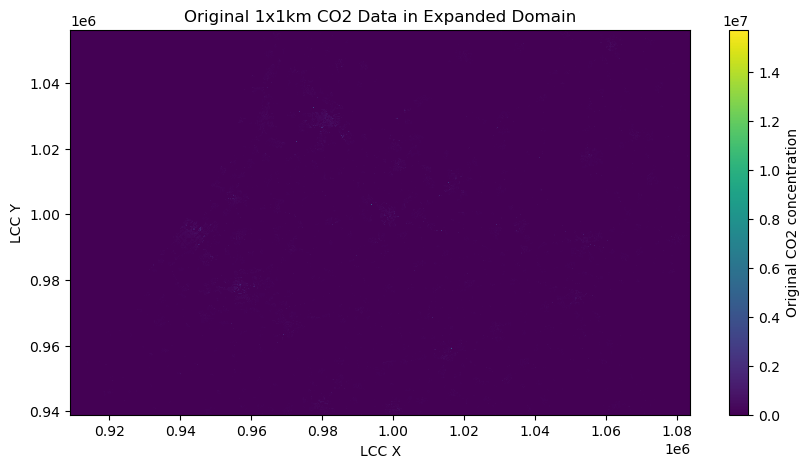

Adjusted original mass (target domain): 15799721150.10, Resampled mass: 15695688187.15
Mass conservation error: -0.66%


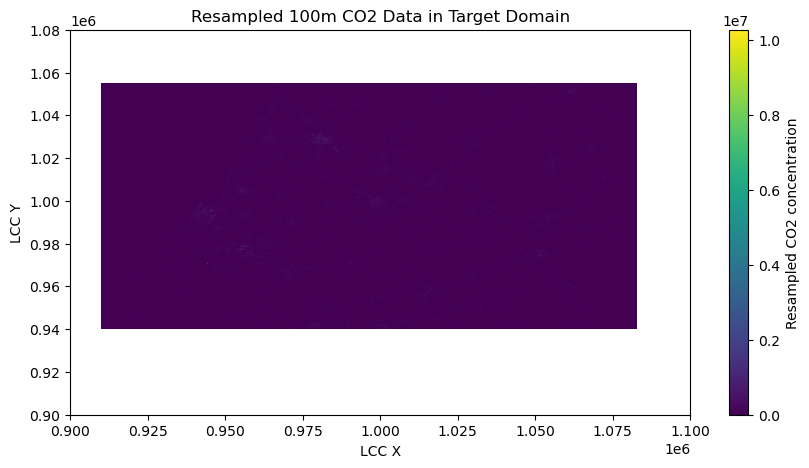

In [1]:
#for SNAP 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from GridDales import GridDales
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import Polygon

# Define transformation class
class Transform:
    def __init__(self, parameters):
        self.parameters = parameters
        self.crs_latlon = 'epsg:4326'
        self.crs_rd = 'epsg:28992'
        # Construct transformation objects
        self.latlon_to_xy_transform = Transformer.from_crs(self.crs_latlon, self.parameters['proj4'])
        self.xy_to_latlon_transform = Transformer.from_crs(self.parameters['proj4'], self.crs_latlon)
        self.rd_to_latlon_transform = Transformer.from_crs(self.crs_rd, self.crs_latlon)
        self.latlon_to_rd_transform = Transformer.from_crs(self.crs_latlon, self.crs_rd)
        self.rd_to_lcc_transform = Transformer.from_crs(self.crs_rd, self.parameters['proj4'])

    def latlon_to_xy(self, lat, lon):
        return self.latlon_to_xy_transform.transform(lat, lon)

    def xy_to_latlon(self, x, y):
        return self.xy_to_latlon_transform.transform(x, y)
    
    def rd_to_latlon(self, x, y):
        return self.rd_to_latlon_transform.transform(x, y)
    
    def latlon_to_rd(self, lat, lon):
        return self.latlon_to_rd_transform.transform(lat, lon)

    def rd_to_lcc(self, x, y):
        return self.rd_to_lcc_transform.transform(x, y)


# Load CSV containing the CO2 data
data_path = "co2_2018_SNAP_2_refined_100m_residual.csv"  #_refined_100m
df = pd.read_csv(data_path)

# Define projection parameters
proj_params = {
    'proj4': "+proj=lcc +lat_1=52.500000 +lat_2=52.500000 +lat_0=52.500000 +lon_0=0.000000 "
              "+k_0=1.0 +x_0=649536.512574 +y_0=1032883.739533 +a=6371229.0 +b=6371229.0"
}


transformer = Transform(proj_params)



# Define LES grid (target grid with 100x100m resolution)
grid_params = {
    'xsize': 172800,
    'ysize': 115200,
    'itot': 1728,
    'jtot': 1152,
    'kmax': 128,
    'dz0': 20,
    'alpha': 0.0,
    'southwest_x': 0.0,  # Placeholder for LCC coordinates of the southwest corner
    'southwest_y': 0.0   # Placeholder for LCC coordinates of the southwest corner
}


# Convert the starting point (50.6N, 1.5E) from LatLon to LCC coordinates
#lat_start, lon_start = 50.6, 1.5
#lcc_start_x, lcc_start_y = transformer.latlon_to_xy(lat_start, lon_start)

lcc_start_x, lcc_start_y=910000, 940000
# Define the target grid's southwest corner in LCC coordinates
grid_params['southwest_x'] = lcc_start_x
grid_params['southwest_y'] = lcc_start_y



les_grid = GridDales(grid_params)

# Generate grid mesh for the target resolution (100x100 m)
les_x, les_y = np.meshgrid(les_grid.xt, les_grid.yt)

# Convert RD to LCC
lcc_x, lcc_y = transformer.rd_to_lcc(df['x'].values, df['y'].values)
df['lcc_x'], df['lcc_y'] = lcc_x, lcc_y

# Now you can create the target grid from this southwest corner
target_x_min = lcc_start_x
target_y_min = lcc_start_y
target_x_max = target_x_min + les_grid.dx * les_grid.itot  # Assuming the grid spans based on dx
target_y_max = target_y_min + les_grid.dy * les_grid.jtot  # Assuming the grid spans based on dy

# Expand the domain slightly in LCC coordinates to ensure we cover a bit larger area than the target
buffer_x = 1000  # 1 km buffer in LCC coordinates (adjust as needed)
buffer_y = 1000  # 1 km buffer in LCC coordinates (adjust as needed)

expanded_target_x_min = target_x_min - buffer_x
expanded_target_x_max = target_x_max + buffer_x
expanded_target_y_min = target_y_min - buffer_y
expanded_target_y_max = target_y_max + buffer_y

# Extract original data within the expanded target domain
mask = (df['lcc_x'] >= expanded_target_x_min) & (df['lcc_x'] <= expanded_target_x_max) &        (df['lcc_y'] >= expanded_target_y_min) & (df['lcc_y'] <= expanded_target_y_max)

# Apply mask to the data
filtered_df = df[mask]

# Create a grid for the original data (1x1 km resolution) based on the expanded domain
# We will now generate the grid using the bounds of the filtered data
original_grid_x, original_grid_y = np.meshgrid(
    np.linspace(filtered_df['lcc_x'].min(), filtered_df['lcc_x'].max(), int((filtered_df['lcc_x'].max() - filtered_df['lcc_x'].min()) / 100)),
    np.linspace(filtered_df['lcc_y'].min(), filtered_df['lcc_y'].max(), int((filtered_df['lcc_y'].max() - filtered_df['lcc_y'].min()) / 100))
)


# Initialize the original CO2 concentration grid (with 1x1 km resolution)
original_co2_grid = np.zeros_like(original_grid_x)

# Loop over the filtered data and assign values to the original grid (1x1 km resolution)
for i in range(len(filtered_df)):
    original_x = filtered_df['lcc_x'].iloc[i]
    original_y = filtered_df['lcc_y'].iloc[i]
    original_co2_value = filtered_df['co2'].iloc[i]

    # Find the closest grid cell in the original 1x1 km resolution grid
    target_x_idx = np.argmin(np.abs(original_grid_x[0, :] - original_x))
    target_y_idx = np.argmin(np.abs(original_grid_y[:, 0] - original_y))

    # Assign the CO2 value to the corresponding grid cell
    original_co2_grid[target_y_idx, target_x_idx] += original_co2_value

# Plot the original CO2 data (1x1km resolution) using pcolormesh
plt.figure(figsize=(10, 5))
plt.pcolormesh(original_grid_x, original_grid_y, original_co2_grid, cmap="viridis", shading='auto')
#plt.ylim(960000, 990000)
#plt.xlim(910000, 940000)
plt.colorbar(label="Original CO2 concentration")
plt.title("Original 1x1km CO2 Data in Expanded Domain")
plt.xlabel("LCC X")
plt.ylabel("LCC Y")
plt.show()



# Calculate the area of each grid cell (in km²) for the resampled 100m grid
cell_area_km2_resampled = (les_grid.dx * les_grid.dy) / 10000 # area in km²

# Initialize resampled CO2 values for the target grid (100m resolution)
resampled_co2 = np.zeros_like(les_x)

# Step 1: Create a RegularGridInterpolator for the original grid (1km resolution)
interp = RegularGridInterpolator(
    (original_grid_y[:, 0]-lcc_start_y, original_grid_x[0, :]-lcc_start_x), 
    original_co2_grid, 
    method='linear',  # Switch from linear to nearest
    bounds_error=False, 
    fill_value=np.nan  # Use NaN instead of 0 to debug missing data
)

# Step 2: Resample onto the target grid (100m resolution) using the interpolator
resampled_co2 = interp((les_y.flatten(), les_x.flatten())).reshape(les_x.shape)

# Create a polygon for the target domain
target_domain = Polygon([
    (expanded_target_x_min, expanded_target_y_min),
    (expanded_target_x_max, expanded_target_y_min),
    (expanded_target_x_max, expanded_target_y_max),
    (expanded_target_x_min, expanded_target_y_max)
])

# Initialize the adjusted original mass
adjusted_original_mass = 0

# Loop over the filtered data and adjust the mass based on overlap
for i in range(len(filtered_df)):
    original_x = filtered_df['lcc_x'].iloc[i]
    original_y = filtered_df['lcc_y'].iloc[i]
    original_co2_value = filtered_df['co2'].iloc[i]

    # Define the original 1 km grid cell (bounding box) for each data point
    x_min = original_x - 500  # 500m buffer for 1x1 km cell
    x_max = original_x + 500
    y_min = original_y - 500
    y_max = original_y + 500

    original_cell = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

    # Calculate overlap between original grid cell and the target domain
    overlap_area = target_domain.intersection(original_cell).area
    original_cell_area = original_cell.area

    # Fraction of the original cell that overlaps with the target domain
    overlap_fraction = overlap_area / original_cell_area

    # Adjust the CO2 mass based on the overlap fraction
    adjusted_original_mass += original_co2_value * overlap_fraction

# Calculate resampled mass
resampled_mass = np.nansum(resampled_co2) * cell_area_km2_resampled

# Calculate mass error
original_mass = np.nansum(filtered_df['co2'].values)  # since original data has 1 km² per cell
mass_error = (resampled_mass - adjusted_original_mass) / adjusted_original_mass * 100

# Print results
print(f"Adjusted original mass (target domain): {adjusted_original_mass:.2f}, Resampled mass: {resampled_mass:.2f}")
print(f"Mass conservation error: {mass_error:.2f}%")

final_resample=resampled_co2* cell_area_km2_resampled

# Plot resampled CO2 data (100x100m resolution) in the target domain


plt.figure(figsize=(10, 5))

# Convert LES x, y coordinates to lat/lon using your existing transformer
lat, lon = transformer.xy_to_latlon(les_x+lcc_start_x, les_y+lcc_start_y)

# Plot in lat/lon space
plt.pcolormesh(les_x+lcc_start_x, les_y+lcc_start_y,final_resample , cmap="viridis", shading='auto',vmax=1000000)
#plt.pcolormesh(les_x, les_y, resampled_co2, cmap="rainbow", shading='auto')
#plt.ylim(np.min(lat)-0.5, np.max(lat)+0.5)
#plt.xlim(np.min(lon)-0.5, np.max(lon)+0.5)

plt.ylim(900000, 1080000)
plt.xlim(900000, 1100000)
plt.colorbar(label="Resampled CO2 concentration")
plt.title("Resampled 100m CO2 Data in Target Domain")
plt.xlabel("LCC X")
plt.ylabel("LCC Y")
plt.show()


# In[199]:

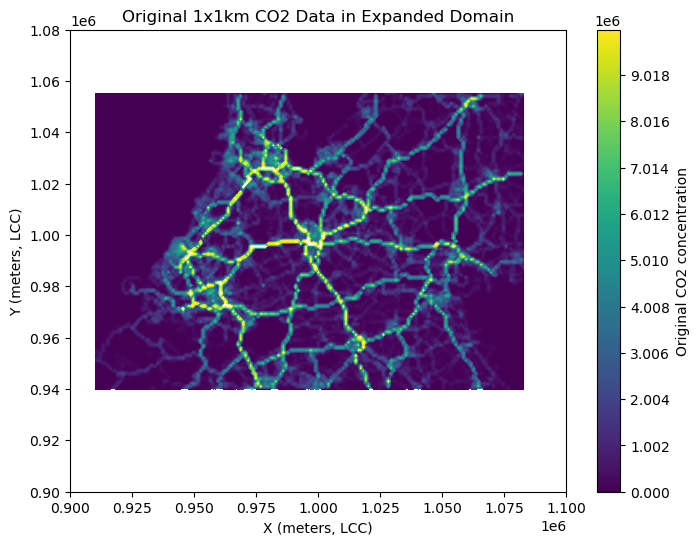

/var/folders/f8/yw2dpdwn7qdgcbst8w8cx4k80000gn/T/ipykernel_24813/1726646289.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_co2_df['lcc_x'] = filtered_co2_df['lcc_x'] - southwest_x
/var/folders/f8/yw2dpdwn7qdgcbst8w8cx4k80000gn/T/ipykernel_24813/1726646289.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_co2_df['lcc_y'] = filtered_co2_df['lcc_y'] - southwest_y


Total CO2 before redistribution: 18280330004.698532
Total CO2 after redistribution: 255404462.46504396
Scaling applied to preserve mass conservation.


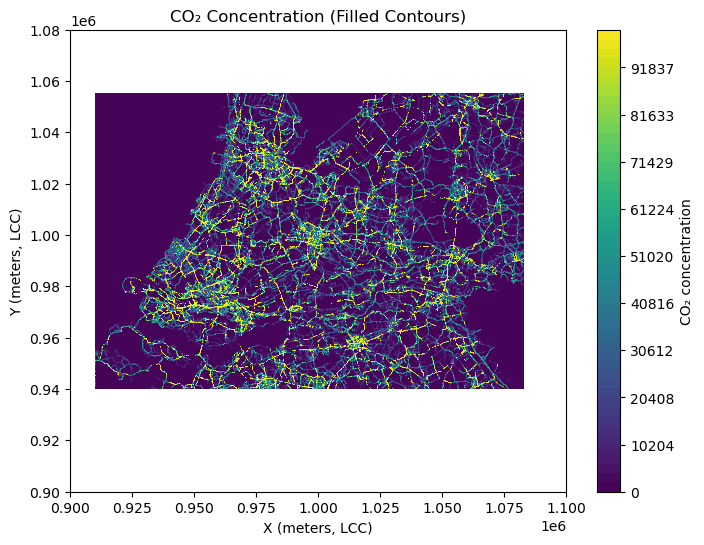

In [17]:
#for SNAP 7

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from GridDales import GridDales
from scipy.interpolate import RegularGridInterpolator
import fiona
import geopandas as gpd
import os
import numpy as np
import pandas as pd
from pyproj import Transformer
from shapely.geometry import Polygon, MultiLineString, LineString
from scipy.interpolate import RegularGridInterpolator
from GridDales import GridDales
import matplotlib.pyplot as plt

# Define transformation class
class Transform:
    def __init__(self, parameters):
        self.parameters = parameters
        self.crs_latlon = 'epsg:4326'
        self.crs_rd = 'epsg:28992'
        # Construct transformation objects
        self.latlon_to_xy_transform = Transformer.from_crs(self.crs_latlon, self.parameters['proj4'])
        self.xy_to_latlon_transform = Transformer.from_crs(self.parameters['proj4'], self.crs_latlon)
        self.rd_to_latlon_transform = Transformer.from_crs(self.crs_rd, self.crs_latlon)
        self.latlon_to_rd_transform = Transformer.from_crs(self.crs_latlon, self.crs_rd)
        self.rd_to_lcc_transform = Transformer.from_crs(self.crs_rd, self.parameters['proj4'])

    def latlon_to_xy(self, lat, lon):
        return self.latlon_to_xy_transform.transform(lat, lon)

    def xy_to_latlon(self, x, y):
        return self.xy_to_latlon_transform.transform(x, y)
    
    def rd_to_latlon(self, x, y):
        return self.rd_to_latlon_transform.transform(x, y)
    
    def latlon_to_rd(self, lat, lon):
        return self.latlon_to_rd_transform.transform(lat, lon)

    def rd_to_lcc(self, x, y):
        return self.rd_to_lcc_transform.transform(x, y)


# Method to read NOx data from a given source (already in RD coordinates)
def read_nox_data(noxdir):
    columns_to_read = ['Shape_Length', 'TVtot_N_sum']

    with fiona.open(os.path.join(noxdir, f'NOx_traffic.gpkg')) as src:
        filtered_features = [{'geometry': feature['geometry'],
                              'properties': {key: feature['properties'][key] for key in columns_to_read}} for feature in src]

    road_network = gpd.GeoDataFrame.from_features(filtered_features)
    road_network['TVtot_N_sum'] = road_network['TVtot_N_sum'] /1000  # Convert to kg/year
    road_network.crs = 'EPSG:28992'  # Confirm that it's in RD coordinates

    return road_network


# Load CO2 emission data (CSV file) in RD coordinates
def load_co2_data(co2_file):
    df = pd.read_csv(co2_file)
    return df





# Function to convert road geometry (MULTILINESTRING or LINESTRING) to LCC and subtract (910000, 940000)
def convert_road_geometry_to_lcc(road_geometry, transformer, origin_x=910000, origin_y=940000):
    # Check if it's a MultiLineString
    if isinstance(road_geometry, MultiLineString):
        road_coords = []
        for line in road_geometry.geoms:  # Use .geoms to iterate over individual LineStrings
            # For each LineString in the MultiLineString, convert coordinates to LCC
            x, y = line.coords.xy
            lcc_coords = np.array([transformer.rd_to_lcc(xi, yi) for xi, yi in zip(x, y)])
            lcc_coords -= np.array([origin_x, origin_y])
            road_coords.append(lcc_coords)
        return road_coords
    elif isinstance(road_geometry, LineString):
        # If it's a single LineString, convert coordinates to LCC
        x, y = road_geometry.coords.xy
        lcc_coords = np.array([transformer.rd_to_lcc(xi, yi) for xi, yi in zip(x, y)])
        lcc_coords -= np.array([origin_x, origin_y])
        
        return lcc_coords
    else:
        raise ValueError("Unsupported geometry type")



# Create a grid for the original data (1x1 km resolution) based on the expanded domain
def create_original_grid(filtered_df):
    # Generate grid using the bounds of the filtered data
    original_grid_x, original_grid_y = np.meshgrid(
        np.linspace(filtered_df['lcc_x'].min(), filtered_df['lcc_x'].max(), int((filtered_df['lcc_x'].max() - filtered_df['lcc_x'].min()) / 1000)),
        np.linspace(filtered_df['lcc_y'].min(), filtered_df['lcc_y'].max(), int((filtered_df['lcc_y'].max() - filtered_df['lcc_y'].min()) / 1000))
    )

    # Initialize the original CO2 concentration grid (with 1x1 km resolution)
    original_co2_grid = np.zeros_like(original_grid_x)

    # Loop over the filtered data and assign values to the original grid (1x1 km resolution)
    for i in range(len(filtered_df)):
        original_x = filtered_df['lcc_x'].iloc[i]
        original_y = filtered_df['lcc_y'].iloc[i]
        original_co2_value = filtered_df['co2'].iloc[i]

        # Find the closest grid cell in the original 1x1 km resolution grid
        target_x_idx = np.argmin(np.abs(original_grid_x[0, :] - original_x))
        target_y_idx = np.argmin(np.abs(original_grid_y[:, 0] - original_y))

        # Assign the CO2 value to the corresponding grid cell
        original_co2_grid[target_y_idx, target_x_idx] += original_co2_value

    return original_grid_x, original_grid_y, original_co2_grid



# Function to filter data based on the expanded target domain
def filter_data_within_expanded_domain(df, transformer, les_grid):
    # Extract target grid parameters from les_grid dictionary
    # Define southwest corner coordinates
    southwest_x = 910000
    southwest_y = 940000
    
    # Define the expanded domain (buffer added)
    buffer_x = 0  # 1 km buffer in LCC coordinates
    buffer_y = 0  # 1 km buffer in LCC coordinates

    target_x_min = lcc_start_x
    target_y_min = lcc_start_y
    target_x_max = target_x_min + les_grid.dx * les_grid.itot
    target_y_max = target_y_min + les_grid.dy * les_grid.jtot

    expanded_target_x_min = target_x_min - buffer_x
    expanded_target_x_max = target_x_max + buffer_x
    expanded_target_y_min = target_y_min - buffer_y
    expanded_target_y_max = target_y_max + buffer_y

    # Convert RD to LCC for both CO2 and NOx data
    lcc_x, lcc_y = transformer.rd_to_lcc(df['x'].values, df['y'].values)
    df['lcc_x'], df['lcc_y'] = lcc_x, lcc_y

    # Filter the data within the expanded domain
    mask = (df['lcc_x'] >= expanded_target_x_min) & (df['lcc_x'] <= expanded_target_x_max) & \
           (df['lcc_y'] >= expanded_target_y_min) & (df['lcc_y'] <= expanded_target_y_max)

    filtered_df = df[mask]
    return filtered_df


def redistribute_co2_to_les_grid(co2_df, road_network, les_grid, transformer, co2_grid_resolution=1000):
    # Initialize an empty grid with the shape of the LES grid (jtot x itot)
    redistributed_co2 = np.zeros((les_grid.jtot, les_grid.itot))

    # Initialize an array to track the number of updates per grid cell
    update_count = np.zeros_like(redistributed_co2)

    total_co2_before = co2_df['co2'].sum()  # Keep track of total CO2 in the original data

    # Loop through each road segment in the road network
    for _, road in road_network.iterrows():
        road_geometry = road['geometry']  # Get the geometry for the road (MULTILINESTRING)
        road_weight = road['TVtot_N_sum']  # Get the weight of the road segment
        road_length = road_geometry.length  # Get the length of the road segment
        
        # Convert the road geometry to LCC coordinates
        road_coords = convert_road_geometry_to_lcc(road_geometry, transformer)

        # Now `road_coords` contains the LCC coordinates for each line segment
        for coords in road_coords:
            # Interpolate CO2 values for each road segment (assuming co2_df contains the LCC coordinates and CO2 values)
            co2_values = np.interp(coords[:, 0], co2_df['lcc_x'].values, co2_df['co2'].values)

            # Ensure that the sum of CO2 values for this road segment is preserved
            total_co2_segment = co2_values.sum()

            # Calculate the total CO2 to redistribute based on the road segment weight
            co2_per_unit_length = total_co2_segment / road_length
            co2_weighted = co2_per_unit_length * road_weight

            # Process the redistributed CO2 emissions
            for i, (x, y) in enumerate(coords):
                # Calculate the corresponding indices in the LES grid based on LCC coordinates
                x_idx = np.argmin(np.abs(les_grid.xt - x))
                y_idx = np.argmin(np.abs(les_grid.yt - y))

                # Ensure indices stay within grid bounds
                x_idx = min(max(x_idx, 0), les_grid.itot - 1)
                y_idx = min(max(y_idx, 0), les_grid.jtot - 1)

                # Area scaling based on grid resolutions
                # Assuming co2_grid_resolution is the resolution of the original CO2 grid (in meters per grid cell)
                area_scale = (co2_grid_resolution ** 2) / (les_grid.dx * les_grid.dy)  # Scale by area difference

                # Add the weighted CO2 value scaled by area difference and increment the update count
                redistributed_co2[y_idx, x_idx] += co2_weighted * area_scale
                update_count[y_idx, x_idx] += 1

    # Normalize the redistributed CO2 by the update count to avoid high values
    redistributed_co2 = np.divide(redistributed_co2, update_count, where=update_count > 0)
    
    redistributed_co2[:,-1]=0
    redistributed_co2[0,:]=0
    redistributed_co2[-1,:]=0
    redistributed_co2[0,:]=0

    # Check if total CO2 is conserved in the redistribution
    total_co2_after = redistributed_co2.sum()
    print(f"Total CO2 before redistribution: {total_co2_before}")
    print(f"Total CO2 after redistribution: {total_co2_after}")

    # Optionally, adjust the redistributed CO2 to ensure conservation (scaling factor)
    if total_co2_before != total_co2_after:
        scaling_factor = total_co2_before / total_co2_after
        redistributed_co2 *= scaling_factor
        print("Scaling applied to preserve mass conservation.")

    return redistributed_co2









# Load NOx data (in RD coordinates)
noxdir = ""
road_network = read_nox_data(noxdir)

# Load CSV containing the CO2 data
data_path = "co2_2018_SNAP_7_residual.csv"  #_refined_100m
co2_df = pd.read_csv(data_path)

# Define projection parameters
proj_params = {
    'proj4': "+proj=lcc +lat_1=52.500000 +lat_2=52.500000 +lat_0=52.500000 +lon_0=0.000000 "
              "+k_0=1.0 +x_0=649536.512574 +y_0=1032883.739533 +a=6371229.0 +b=6371229.0"
}


transformer = Transform(proj_params)



# Define LES grid (target grid with 100x100m resolution)
grid_params = {
    'xsize': 172800,
    'ysize': 115200,
    'itot': 1728,
    'jtot': 1152,
    'kmax': 128,
    'dz0': 20,
    'alpha': 0.0,
    'southwest_x': 0.0,  # Placeholder for LCC coordinates of the southwest corner
    'southwest_y': 0.0   # Placeholder for LCC coordinates of the southwest corner
}


# Filter CO2 data to be within the expanded target domain
#filtered_co2_df = filter_data_within_expanded_domain(co2_df, transformer, grid_params)
filtered_co2_df = filter_data_within_expanded_domain(co2_df, transformer, les_grid)

# Create original CO2 grid (1x1 km resolution)
original_grid_x, original_grid_y, original_co2_grid = create_original_grid(filtered_co2_df)

# Assuming les_x, les_y, final_resample, lcc_start_x, lcc_start_y are defined

plt.figure(figsize=(8, 6))

# Define contour levels to set a maximum value
levels = np.linspace(0, 10000000, 500)  # Adjust the number of levels as needed

contour = plt.contourf(original_grid_x, original_grid_y, original_co2_grid, levels=levels, cmap="viridis")

plt.colorbar(contour, label="Original CO2 concentration")  # Add colorbar for reference

# Set limits
plt.ylim(900000, 1080000)
plt.xlim(900000, 1100000)

plt.xlabel("X (meters, LCC)")
plt.ylabel("Y (meters, LCC)")
plt.title("Original 1x1km CO2 Data in Expanded Domain")

plt.show()

# Define southwest corner coordinates
southwest_x = 910000
southwest_y = 940000

# Subtract southwest_x and southwest_y from the lcc_x and lcc_y columns
filtered_co2_df['lcc_x'] = filtered_co2_df['lcc_x'].copy() - southwest_x
filtered_co2_df['lcc_y'] = filtered_co2_df['lcc_y'].copy() - southwest_y

# Redistribute CO2 emissions to LES grid
final_resample = redistribute_co2_to_les_grid(filtered_co2_df, road_network,les_grid, transformer )

# Assuming les_x, les_y, final_resample, lcc_start_x, lcc_start_y are defined

plt.figure(figsize=(8, 6))

# Define contour levels to set a maximum value
levels = np.linspace(0, 100000, 50)  # Adjust the number of levels as needed

contour = plt.contourf(les_x + lcc_start_x, les_y + lcc_start_y, final_resample, levels=levels, cmap="viridis")

plt.colorbar(contour, label="CO₂ concentration")  # Add colorbar for reference

# Set limits
plt.ylim(900000, 1080000)
plt.xlim(900000, 1100000)

plt.xlabel("X (meters, LCC)")
plt.ylabel("Y (meters, LCC)")
plt.title("CO₂ Concentration (Filled Contours)")

plt.show()

In [18]:
import numpy as np
from netCDF4 import Dataset

# Assume the necessary data is already available:
#  - redistributed_co2 (2D array)
#  - les_grid.xt (1D array)
#  - les_grid.yt (1D array)
#  - lat (2D array)
#  - lon (2D array)

# Create the new NetCDF file
ncfile = Dataset('HARM_snap_7_all.nc', 'w', format='NETCDF4')

# Define dimensions
ncfile.createDimension('x', len(les_grid.xt))  # Number of x points (columns)
ncfile.createDimension('y', len(les_grid.yt))  # Number of y points (rows)

# Create variables
x = ncfile.createVariable('x', 'f4', ('x',))  # 1D variable for x coordinates
y = ncfile.createVariable('y', 'f4', ('y',))  # 1D variable for y coordinates
lat_cor = ncfile.createVariable('lat', 'f4', ('y', 'x'))  # 2D variable for latitudes
lon_cor = ncfile.createVariable('lon', 'f4', ('y', 'x'))  # 2D variable for longitudes
co2 = ncfile.createVariable('co2', 'f4', ('y', 'x'))  # 2D variable for CO2 emissions

# Assign values to variables
x[:] = les_grid.xt+lcc_start_x
y[:] = les_grid.yt+lcc_start_y
lat_cor[:, :] = lat # 2D latitudes
lon_cor[:, :] = lon # 2D longitudes
co2[:, :] = final_resample  # CO2 emissions

# Add global attributes (optional)
ncfile.title = 'co2 Emissions kg/year'
ncfile.history = 'Created by Python script'

# Close the NetCDF file
ncfile.close()

print('NetCDF file created successfully')

NetCDF file created successfully
